## Team members

* Eric Romero kramer
* Mihir Patil
* Swaroop Bhandary K

In [4]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import glob
import keras
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
# import keras_metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix  
from __future__ import division

## TODO:
* Implement a confusion matrix
* Implement grid search to find the right configuration
* Use F measure as we want recall of 1, no false negatives

In [5]:
fleisch = pd.read_excel('Archive_files/Archiv/Fleisch.xls').astype(float)
stoff =pd.read_excel('Archive_files/Archiv/Stoff.xls').astype(float)
leder = pd.read_excel('Archive_files/Archiv/Leder.xls').astype(float)
holz = pd.read_excel('Archive_files/Archiv/Holz.xls').astype(float)
haut = pd.read_excel('Archive_files/Archiv/Referenz-Haut_6-Klassen.xls').astype(float)
skin = pd.read_csv('Archive_files/Archiv/2016skin.csv', sep=';', decimal=',').astype(float)
skin.dropna(axis=0, inplace=True)
material_fake = pd.read_csv('Archive_files/Archiv/2016material-fake.csv', sep=';', decimal=',').astype(float)
material_fake.dropna(axis=0, inplace=True)

print('================================================================')
print(' Data sets shapes')
print('Fleisch ', fleisch.shape)
print('Stoff ', stoff.shape)
print('Leder ', leder.shape)
print('Haut ', haut.shape)
print('Holz ', holz.shape)
print('Skin ', skin.shape)
print('Material Fake ', material_fake.shape)

 Data sets shapes
Fleisch  (121, 71)
Stoff  (121, 11)
Leder  (121, 30)
Haut  (121, 7)
Holz  (121, 63)
Skin  (1021, 1112)
Material Fake  (1021, 33)


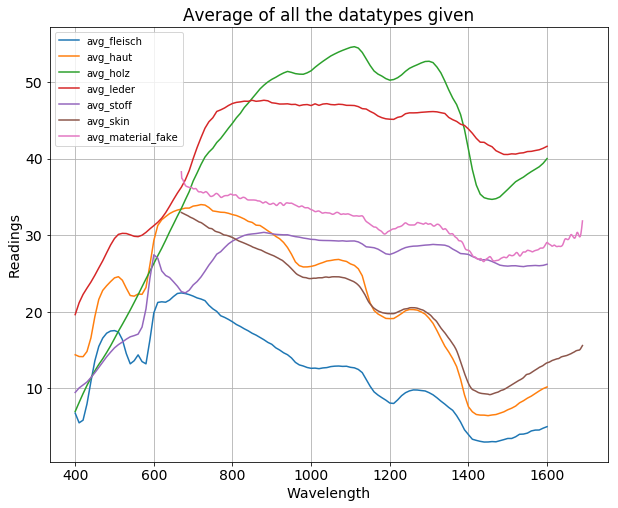

In [6]:
avg_fleisch = np.array(fleisch.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_leder = np.array(leder.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_holz = np.array(holz.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_stoff = np.array(stoff.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_haut = np.array(haut.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_skin = np.array(skin.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_material_fake = np.array(material_fake.iloc[:,1:].mean(axis = 1))[np.newaxis].T

wavelength = np.array(fleisch['nm'])[np.newaxis].T
wavelength_2016 = np.array(skin['nm'])[np.newaxis].T

# Plot the average values
plt.figure(figsize=[10,8])
plt.rcParams.update({'font.size': 14})

# Plot the different data 
plt.plot(wavelength,avg_fleisch,label='avg_fleisch')
plt.plot(wavelength,avg_haut,label='avg_haut')
plt.plot(wavelength,avg_holz,label='avg_holz')
plt.plot(wavelength,avg_leder,label='avg_leder')
plt.plot(wavelength,avg_stoff,label='avg_stoff')
plt.plot(wavelength_2016,avg_skin,label='avg_skin')
plt.plot(wavelength_2016,avg_material_fake,label='avg_material_fake')

# Plot properties
plt.grid()
plt.title('Average of all the datatypes given')
plt.xlabel('Wavelength')
plt.ylabel('Readings')
plt.legend(loc='upper left',prop={'size': 10})

In [7]:
from sklearn.decomposition import PCA

def dataCleanup(data):

    gross_avg = np.array(data.iloc[:,1:].mean(axis = 1))

    # print('average of the combined dataset={}'.format(gross_avg.shape))

    mean_removed_data = data.subtract(gross_avg, axis = 0)
    
    pca = PCA(n_components=5)

    pca.fit(mean_removed_data)

    cleaned_data = pca.transform(mean_removed_data)    

    print('number of components selected to maintain = {}'.format(pca.n_components_))
    print('the variance ratio for each component = {}'.format(pca.explained_variance_ratio_))

    return cleaned_data

In [8]:
print('=========================================================================')
print("Performing PCA on the dataset to use the features with more relevance")
print('=========================================================================')

print('------------- FLEISCH -------------')
fleisch_cleaned = dataCleanup(fleisch.drop(columns="nm"))
print('-------------   HAUT  -------------')
haut_cleaned = dataCleanup(haut.drop(columns="nm"))
print('-------------   SKIN  -------------')
skin_cleaned = dataCleanup(skin.drop(columns="nm"))
# print('-----------   MATERIAL  -----------')
# material_cleaned = whiten(material.drop(columns="nm"))
print('---------   MATERIAL FAKE  --------')
material_fake_cleaned = dataCleanup(material_fake.drop(columns="nm"))
print('-------------   HOLZ  -------------')
holz_cleaned = dataCleanup(holz.drop(columns="nm"))
print('-------------  LEDER  -------------')
leder_cleaned = dataCleanup(leder.drop(columns="nm"))
print('-------------  STOFF  -------------')
stoff_cleaned = dataCleanup(stoff.drop(columns="nm"))
            
print('=========================================================================')
print("Creating the labels to train the network")
print('=========================================================================')
fleisch_labels = np.ones((len(fleisch_cleaned),1))
print("Fleisch Labels: ",fleisch_labels.shape)

haut_labels = np.ones((len(haut_cleaned),1))
print("Haut Labels: ",haut_labels.shape)

skin_labels = np.ones((len(skin_cleaned),1))
print("Skin Labels: ",skin_labels.shape)

# material_labels = np.zeros((len(material_cleaned),1))
# print("Material Labels: ",material_labels.shape)

material_fake_labels = np.zeros((len(material_fake_cleaned),1))
print("Material Fake Labels: ",material_fake_labels.shape)

holz_labels = np.zeros((len(holz_cleaned),1))
print("Holz Labels: ",holz_labels.shape)

leder_labels = np.zeros((len(leder_cleaned),1))
print("Leder Labels: ",leder_labels.shape)

stoff_labels = np.zeros((len(stoff_cleaned),1))
print("Stoff Labels: ", stoff_labels.shape)

print('=========================================================================')
print("Combining all the datasets and labels")
print('=========================================================================')

ultimate_dataset = np.vstack((fleisch_cleaned, holz_cleaned, leder_cleaned, haut_cleaned,\
                             stoff_cleaned, skin_cleaned, material_fake_cleaned, haut_cleaned))
print("Dataset size: ", ultimate_dataset.shape)
ultimate_labels = np.vstack((fleisch_labels, holz_labels, leder_labels, haut_labels,\
                            stoff_labels, skin_labels, material_fake_labels, haut_labels))
print("Dataset labels size: ", ultimate_labels.shape)

df_total = np.hstack((ultimate_dataset, ultimate_labels))
df_shuffled = shuffle(df_total)

Performing PCA on the dataset to use the features with more relevance
------------- FLEISCH -------------
number of components selected to maintain = 5
the variance ratio for each component = [0.49438838 0.41809529 0.05047013 0.01283651 0.01124949]
-------------   HAUT  -------------
number of components selected to maintain = 5
the variance ratio for each component = [9.16839731e-01 4.61027036e-02 3.46245442e-02 2.03902143e-03
 3.94000293e-04]
-------------   SKIN  -------------
number of components selected to maintain = 5
the variance ratio for each component = [0.51215803 0.17534816 0.10841763 0.05867447 0.02920357]
---------   MATERIAL FAKE  --------
number of components selected to maintain = 5
the variance ratio for each component = [0.57449839 0.21529934 0.1165865  0.03039278 0.01444067]
-------------   HOLZ  -------------
number of components selected to maintain = 5
the variance ratio for each component = [0.63740184 0.26904605 0.0667461  0.0104745  0.00637513]
------------- 

## Implementing MLP for the cleaned data

In [13]:
data_array = np.array(df_shuffled)
X = data_array[:, :-1]
Y = data_array[:, -1]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)  

In [14]:
def MLP(X_train, X_test, Y_train, Y_test):  # create model
    model = Sequential()
    model.add(Dense(12, input_dim=5, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', keras_metrics.recall()])
    # Fit the model
    results = model.fit(X_train, Y_train, epochs=100, batch_size=10, \
                        validation_data = (X_test, Y_test), verbose = 0)
    return model
model = MLP(X_train, X_test, Y_train, Y_test)

#### Build the confusion matrix to validate the output

In [15]:
print model.evaluate(X_test, Y_test, verbose=0)
y_pred = model.predict_classes(X_test)
print('confusion matrix is')
print(confusion_matrix(Y_test, y_pred))  

[0.0880657354645458, 0.983754512635379, 0.9796169123168934]
confusion matrix is
[[266   3]
 [  6 279]]


### Implementing kfold

In [16]:
#define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
accuracy_scores = []
recall_scores = []

for train, test in kfold.split(X, Y):
    model = Sequential()
    model.add(Dense(12, input_dim=5, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', keras_metrics.recall()])
    model.fit(X[train], Y[train], epochs = 100, batch_size = 50, validation_data = (X[test], Y[test]), verbose=0)
    print('======================================================')
    y_pred = model.predict_classes(X[test])
    scores = model.evaluate(X[test], Y[test], verbose=0)
    conf_matrix = confusion_matrix(Y[test], y_pred)
    recall = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
    print('confusion matrix is')
    print(conf_matrix)
    print(recall)
    print('======================================================')
    accuracy_scores.append(scores[1])
    recall_scores.append(recall)
    
print("Average accuracy %.2f%% (+/- %.2f%%)" % (np.mean(accuracy_scores), np.std(accuracy_scores)))
print("Average recall %.2f%% (+/- %.2f%%)" % (np.mean(recall_scores), np.std(recall_scores)))    

confusion matrix is
[[269   8]
 [ 34 243]]
0.8772563176895307
confusion matrix is
[[273   4]
 [ 17 260]]
0.9386281588447654
confusion matrix is
[[269   8]
 [ 34 243]]
0.8772563176895307
confusion matrix is
[[260  17]
 [ 14 263]]
0.9494584837545126
confusion matrix is
[[261  15]
 [ 12 264]]
0.9565217391304348
Average accuracy 0.94% (+/- 0.01%)
Average recall 0.92% (+/- 0.04%)


In [62]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(ultimate_dataset, ultimate_labels, test_size = 0.20)  

In [70]:
from sklearn.metrics import classification_report, confusion_matrix  


def svm_evaluator(X, y, cs, gm = None):
    print('===================================')
    print('C:', cs)
    print('-----------------------------------')
    svclassifier.fit(X_train, y_train) 
    y_pred = svclassifier.predict(X_test) 
    print(confusion_matrix(y_test,y_pred))  
    print(classification_report(y_test,y_pred)) 
    print('===================================')
    
    
    

In [71]:
from sklearn.svm import SVC 
c = [0.001, 0.01, 0.1, 1, 10]
g = [0.001, 0.01, 0.1, 1]

for cs in c:
    svclassifier = SVC(kernel= 'linear',C = cs)  
    svm_evaluator(X_train, y_train, cs)
         

C: 0.001
-----------------------------------
[[266   0]
 [288   0]]
             precision    recall  f1-score   support

        0.0       0.48      1.00      0.65       266
        1.0       0.00      0.00      0.00       288

avg / total       0.23      0.48      0.31       554

C: 0.01
-----------------------------------
[[266   0]
 [288   0]]
             precision    recall  f1-score   support

        0.0       0.48      1.00      0.65       266
        1.0       0.00      0.00      0.00       288

avg / total       0.23      0.48      0.31       554

C: 0.1
-----------------------------------
[[266   0]
 [288   0]]
             precision    recall  f1-score   support

        0.0       0.48      1.00      0.65       266
        1.0       0.00      0.00      0.00       288

avg / total       0.23      0.48      0.31       554

C: 1
-----------------------------------
[[266   0]
 [288   0]]
             precision    recall  f1-score   support

        0.0       0.48      1.00    